In [1]:
from ast import Return
import math
import sys
import random
import cv2
import numpy as np
from matplotlib.path import Path

In [2]:
import cv2

In [2]:
import sys
import cv2
from importlib_metadata import re
import numpy as np
from PIL import Image
from scipy.ndimage.measurements import label,find_objects,center_of_mass
import math
import os

In [3]:

def get_random_color():
    """获取一个随机的颜色"""
    #random.uniform(0, 100)
    r = lambda: random.uniform(0,1)
    return [r(),r(),r(),1]

def extract_contour(r_img):
    """传入一个图像，返回该图像的所有mask的边界轮廓矩阵
    """
    img = cv2.cvtColor(np.asarray(r_img),cv2.COLOR_RGB2BGR)
    
    gray        = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 彩色图变灰度图
    _,binary    = cv2.threshold(gray,127,255,cv2.THRESH_BINARY) # 灰度图变二值图
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 根据二值图找轮廓
    # cv2.drawContours(img,contours,-1,(0,0,255),1) # 把轮廓画在原图上（0,0,255） 表示 RGB 三通道，红色
    return contours

def calculate_two_central_points(contour_pixel_xy_list):
    """计算两个假中心点

    Args:
        contour_pixel_xy_list (np.array): 一个目标的所有边界像素点坐标
    """ 
    num_pixel           = len(contour_pixel_xy_list)
    # 获取四个点的坐标
    first_xy            = contour_pixel_xy_list[0]
    half_xy             = contour_pixel_xy_list[int(num_pixel/2)]
    quarter_xy          = contour_pixel_xy_list[int(num_pixel/4)]
    three_quarters_xy   = contour_pixel_xy_list[(int(num_pixel/4)) + int((num_pixel/2)) ]
    # 计算第一个假中心点
    central_point_1_x   = ((math.fabs(first_xy[0][0] - half_xy[0][0])) / 2) + min(first_xy[0][0],half_xy[0][0])
    central_point_1_y   = ((math.fabs(first_xy[0][1] - half_xy[0][1])) / 2) + min(first_xy[0][1],half_xy[0][1])
    central_points_1_xy = [central_point_1_x,central_point_1_y]
    # 计算第二个假中心点
    central_point_2_x   = ((math.fabs(quarter_xy[0][0] - three_quarters_xy[0][0])) / 2) + min(quarter_xy[0][0],three_quarters_xy[0][0])
    central_point_2_y   = ((math.fabs(quarter_xy[0][1] - three_quarters_xy[0][1])) / 2) + min(quarter_xy[0][1],three_quarters_xy[0][1])
    central_points_2_xy = [central_point_2_x,central_point_2_y]
    # 
    central_points      = []
    central_points.append(central_points_1_xy)
    central_points.append(central_points_2_xy)
    central_points      = np.array(central_points)
    central_points.reshape((2,2))
    
    return central_points

def calculate_central_points(contours):
    """传入一张图像的所有边界矩阵，，依次遍历目标然后调用calculate_central_points，返回该图像的所有假中心点的矩阵
    """
    central_points          = []
    for i in range(len(contours)):
        two_central_points  = calculate_two_central_points(contours[i])
        central_points.append(two_central_points)
    central_points          = np.array(central_points)
    # print(central_points_list)
    return central_points


def is_central_points_on_polygons(contour,central_points):
    """
    判断两个假中心点是否在轮廓内
    """
    # cv2.pointPolygonTest只接受元组
    central_points_1_xy     = (central_points[0][0],central_points[0][1])
    central_points_2_xy     = (central_points[1][0],central_points[1][1])
    distance_point1             = cv2.pointPolygonTest(contour,
                                                   central_points_1_xy, True)
    distance_point2             = cv2.pointPolygonTest(contour,
                                                   central_points_2_xy, True)
    if ((distance_point2 or distance_point1) >= 0) :      
        return True
    elif (-10 <= (distance_point1 and distance_point2) < 0 ):
        return True
    else:
        return False

def compare_area(contours_list,m,n,now_img_id):
    """
    计算两个边界矩阵面积的大小,返回较大值index
    """
    area_m      = cv2.contourArea(contours_list[now_img_id - 1][m - 1])
    area_n      = cv2.contourArea(contours_list[now_img_id - 2][n - 1])
    max_contour = max(area_m,area_n)
    # 返回m/n
    if max_contour == area_m:
        return "m"
    else:
        return "n"

           
             
def IsSameRock(m,n,now_img_id,contours_list,central_points_list):
    """
    两边界矩阵属于同一个砾石，给予相同的砾石编号
    """
    max_id      = compare_area(contours_list,m,n,now_img_id)
    if max_id   == "m":
        flag    = is_central_points_on_polygons(contours_list[now_img_id - 1][m - 1],
                                                central_points_list[now_img_id - 2][n - 1])
    else:
        flag    = is_central_points_on_polygons(contours_list[now_img_id - 2][n - 1],
                                                central_points_list[now_img_id - 1][m - 1])
    return flag      


def IsSameRock_2(m,n,now_img_id,contours_list,central_points_list):
    """
    两边界矩阵属于同一个砾石，给予相同的砾石编号
    """
    max_id      = compare_area(contours_list,m,n,now_img_id)
    if max_id   == "m":
        xq = [central_points_list[now_img_id - 2][n - 1][0][0],
              central_points_list[now_img_id - 2][n - 1][0][1]]
        yq = [central_points_list[now_img_id - 2][n - 1][1][0],
              central_points_list[now_img_id - 2][n - 1][1][1]]
        xv = []
        yv = []
        for i in range(len(contours_list[now_img_id - 1][m - 1])):
            xv.append(contours_list[now_img_id - 1][m - 1][i][0][0])
            yv.append(contours_list[now_img_id - 1][m - 1][i][0][1])
        xq = np.array(xq)
        yq = np.array(yq)
        xv = np.array(xv)
        yv = np.array(yv)
        _,flag     = inpolygon(xq,yq,xv,yv)
    else:
        xq = [central_points_list[now_img_id - 1][m - 1][0][0],
              central_points_list[now_img_id - 1][m - 1][0][1]]
        yq = [central_points_list[now_img_id - 1][m - 1][1][0],
              central_points_list[now_img_id - 1][m - 1][1][1]]
        xv = []
        yv = []
        for i in range(len(contours_list[now_img_id - 2][n - 1])):
            xv.append(contours_list[now_img_id - 2][n - 1][i][0][0])
            yv.append(contours_list[now_img_id - 2][n - 1][i][0][1])
        xq = np.array(xq)
        yq = np.array(yq)
        xv = np.array(xv)
        yv = np.array(yv)
        _,flag    = inpolygon(xq,yq,xv,yv)
    if (flag[0] or flag[1]) == True:
        return True
    else:
        return False


def inpolygon(xq, yq, xv, yv):
    """
    reimplement inpolygon in matlab
    :type xq: np.ndarray
    :type yq: np.ndarray
    :type xv: np.ndarray
    :type yv: np.ndarray
    """
    # 合并xv和yv为顶点数组
    vertices = np.vstack((xv, yv)).T
    # 定义Path对象
    path = Path(vertices)
    # 把xq和yq合并为test_points
    test_points = np.hstack([xq.reshape(xq.size, -1), yq.reshape(yq.size, -1)])
    # 得到一个test_points是否严格在path内的mask，是bool值数组
    _in = path.contains_points(test_points)
    # 得到一个test_points是否在path内部或者在路径上的mask
    _in_on = path.contains_points(test_points, radius=-1e-10)
    # 得到一个test_points是否在path路径上的mask
    _on = _in ^ _in_on
    
    return _in_on, _on


In [4]:
rocks_img_path = r"E:\\My Projects\\rocks_view\\git_ignore\\test\\total_result-01-18"# 
import os
rocks_images_name = os.listdir(rocks_img_path) 

In [5]:
r_imgs = []
contours_list = []

In [6]:
for i in range(len(rocks_images_name)):
        rock_img = Image.open(os.path.join(rocks_img_path,rocks_images_name[i])) 
        r_imgs.append(rock_img)
# 计算每个图像的所有mask的边界矩阵
for i in range(len(r_imgs)):
    contours = extract_contour(r_imgs[i])
    contours = np.array(contours)
    contours_list.append(contours)
# contours_list = np.array(contours_list)



# 计算每个图像中的所有mask的假中心点
central_points_list = []
for i in range(len(r_imgs)):
    central_points = calculate_central_points(contours_list[i])
    central_points_list.append(central_points)
central_points_list = np.array(central_points_list)

    

In [14]:
# 绘制绿色轮廓
img = cv2.imread(os.path.join(rocks_img_path,rocks_images_name[1]))
cv2.drawContours(img, contours_list[1], 1, (0,255,0), 2)

cv2.imshow("draw", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
central_points_1 = calculate_two_central_points(contours_list[1][1])

In [7]:
def plot_central_points(img_index,contours):
    # 绘制绿色轮廓
    img = cv2.imread(os.path.join(rocks_img_path,rocks_images_name[img_index]))
    font = cv2.FONT_HERSHEY_SIMPLEX
    central_points1_list = []
    for i in range(len(contours)):
        color = get_random_color()
        color = (int(color[0] * 255),int(color[1] * 255),int(color[2] * 255))
        central_points = calculate_two_central_points(contours[i])
        central_points1 = (int(central_points[0][0]),int(central_points[0][1]))
        central_points2 = (int(central_points[1][0]),int(central_points[1][1]))
        central_points1_list.append(central_points1)
        cv2.drawContours(img, contours[i], -1, color, 2)
        cv2.circle(img,central_points1,1,color,4)
        cv2.circle(img,central_points2,1,color,4)
        cv2.putText(img, str(i), central_points2, font, 1,color, 1)
    print(contours[1])
    cv2.imshow("draw", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [20]:
area_m      = cv2.contourArea(contours_list[0][6])
area_n      = cv2.contourArea(contours_list[1][8])

In [22]:
area_n

595.5

In [23]:
flag = is_central_points_on_polygons(contours_list[1][8],central_points_list[0][6])
flag

True

In [9]:
plot_central_points(0,contours_list[0])

[[[224 390]]

 [[223 391]]

 [[221 391]]

 [[220 392]]

 [[219 392]]

 [[214 397]]

 [[214 398]]

 [[213 399]]

 [[213 400]]

 [[212 401]]

 [[212 406]]

 [[213 407]]

 [[213 408]]

 [[214 409]]

 [[215 409]]

 [[216 410]]

 [[217 410]]

 [[218 411]]

 [[223 411]]

 [[224 410]]

 [[228 410]]

 [[229 409]]

 [[232 409]]

 [[235 406]]

 [[235 405]]

 [[234 404]]

 [[234 403]]

 [[233 402]]

 [[233 401]]

 [[232 400]]

 [[232 399]]

 [[231 398]]

 [[231 397]]

 [[230 396]]

 [[230 395]]

 [[229 394]]

 [[229 393]]

 [[228 392]]

 [[227 392]]

 [[226 391]]

 [[225 391]]]


In [17]:
cv2.circle(img,(int(central_points_1[0][0]),int(central_points_1[0][1])),1,(0,255,0),4)
cv2.imshow("draw", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
central_points_1

array([[311.5, 415. ],
       [317.5, 408. ]])

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, "P", (int(central_points_1[0][0]),int(central_points_1[0][1])), font, 1, (0, 255, 0), 1)

In [13]:
cv2.imshow("draw", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

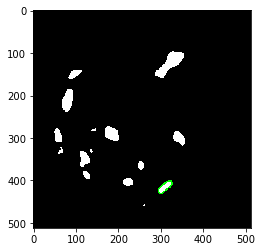

In [22]:
import matplotlib.pyplot as plt
plt.imshow(img)

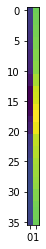

In [39]:
plt.imshow(contours_list[1][1][:,0,: ])

In [23]:
point1 = central_points_list[1]

In [28]:
point1[1]

array([[311.5, 415. ],
       [317.5, 408. ]])

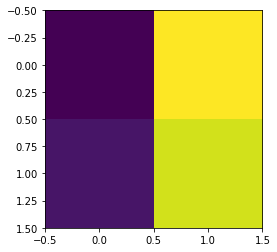

In [27]:
plt.imshow(point1[1])

In [35]:
point1= (central_points_list[1][0][0][0],central_points_list[1][0][0][1])

In [37]:
point1

(261.0, 457.5)

In [33]:
flag = cv2.pointPolygonTest(contours_list[1][1],(central_points_list[1][0][0][0],central_points_list[1][0][0][1]),False)

In [34]:
flag

-1.0